In [2]:
from bs4 import BeautifulSoup
from collections import Counter
from collections import defaultdict
from io import BytesIO
import math
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag as word_type
import numpy as np
import pandas as pd
from PIL import Image
import pytesseract
import re
import requests
import string

In [3]:
df = pd.read_csv("./data/companies_to_productize.csv", encoding="ISO-8859-1", dtype=str)
categories = []

with open("saved_productization_results.txt", "r") as f:
    for line in f.readlines():
        categories.append(line)
df["products"] = categories

import ast

def find_top_product(products):
    classification = ast.literal_eval(products)["results"]
    
    if len(classification) > 0:
        # only grab the top product category
        # most_specific = classification[0][0].split("> ")[-1]
        # return most_specific
        results = []
        for product in classification:
            # grab the most specific product category for each of the results
            # results.append((product[0].split(">")[-1].strip(), product[1]))
            results.append((product[0], product[1]))
        return results
    else:
        return None
    

df["product_scores"] = df["products"].apply(lambda x: find_top_product(x))

In [54]:
def aggregate_company_scores(emails):

    company_categories = {}
    
    for email_score in emails["product_scores"]:
        if email_score != None:
            for score in email_score:
                product = score[0]
                value = score[1]
                
                if product in company_categories:
                    company_categories[product] = company_categories[product] + value
                else:
                    company_categories[product] = value
    categories = list(company_categories.items())
    categories.sort(key=lambda tup: tup[0])
    return(categories)
        
    

companies = df.groupby("name")
dataframe_arr = []

for company, group in companies:    
    score = aggregate_company_scores(group)
    for s in score:
        dataframe_arr.append({"company": company.split(" ")[0], "label": s[0], "score": s[1]})

score_df = pd.DataFrame(dataframe_arr)

/Users/carl/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


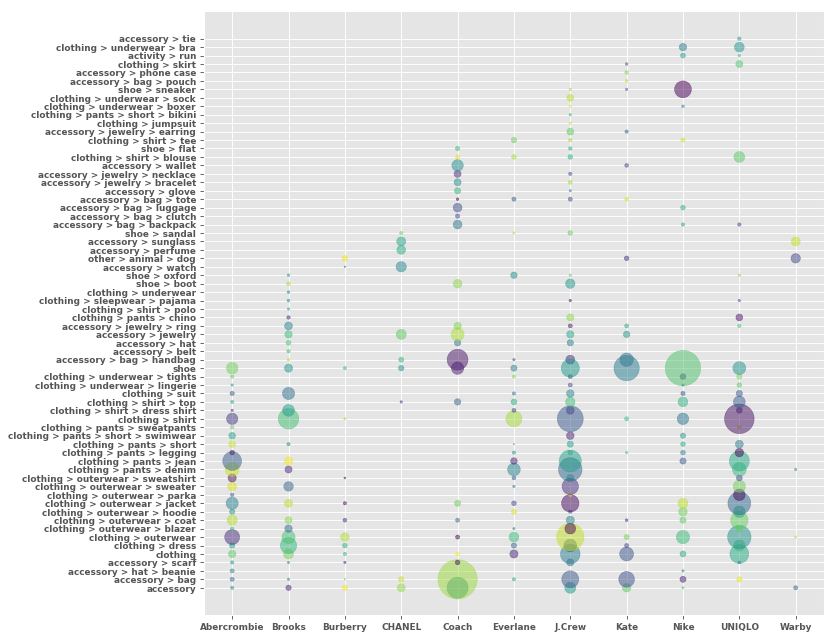

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = score_df["company"].values
y = score_df["label"].values
size = score_df["score"].values * 10

font = {'family' : 'helvetica',
        'weight' : 'bold',
        'size'   : 8}

plt.rc('font', **font)
plt.figure(figsize=(10, 10), dpi= 80)
plt.scatter(x, y, s=size, c=np.random.rand(len(x)), alpha=0.5)
plt.show()